# What is post-processing? 

To run a full radiative transfer model and create a spectrum, at a minimum we need: 

1. temperature-pressure profiles 
2. chemical abundance profiles 
3. basic planetary/stellar properties (radius, mass, etc) 

This would be considered a basic cloud-free model. We could also increase complexity by adding a cloud model, which would add: 

1. optical depth of the cloud 
2. single scattering albedo profile 
3. asymmetry profile 


In reality, chemistry, temperature, and clouds are all related to each other. Temperature dictates cloud formation, clouds affect the energy budget, which feeds back to the temperature. Pairing all three models together is often referred to as a "self-consistent" model. Self-consistent models (especially in 2 or 3 dimensions) become very computation expensive.

Therefore often times, especially in the case of 3D modeling, we don't get back all of these inputs. Yet, we there are many cases where we would still to explore the effect that, for example, clouds would have on the spectrum. This is where post-processing can help. We can take, for example, a starting temperature map, and compute a chemical profile based on that map (or similarly for clouds). 

In these next tutorials, we will explore post-processing of chemistry, and clouds. We will discuss different regridding methods to speed up calculations. Here is a basic diagram that illustrates the various post-processing steps that lead up to computing a full spectrum. 

![workflow-phase.png](workflow-phase.png)

# Post-Process 3D Chemistry Input


In this notebook you will learn: 
1. How to post- process chemistry to an existing xarray


You should already know: 
1. How to format and regrid an `xarray` dataset

Next notebook you will learn:
1. How to create spectra and phase curves from 3D input

In [1]:
import pandas as pd
import numpy as np
import xarray as xr

from picaso import justdoit as jdi
from picaso import justplotit as jpi

In [2]:
gcm_out =  jdi.HJ_pt_3d(as_xarray=True)

## Post-Process Chemistry: User Options

1. User-defined input: this would only be used to explore simplistic cases (e.g. 100% H2O, or 50/50 H2/H2O). It also might be the case that you have abundance models from elsewhere (e.g. 3D model or GCM) and want to add it to your pressure/temperature `xarray` 

2. Computationally intensive route: Usually GCM output is at a very high spatial resolution -- higher than what is needed to post-process spectra. If you want, you can grab chemistry for every single `lat` x `lon` point in your grid first. Then, regrid after. 
    - Pro: you would only have to run it once, then you could regrid to different spatial resolutions later. 
    - Con: computationally expensive (e.g. 128 x 64 pts x ~1 second = 2 hours per model .. though the exact time depends on how many altitude points you have) 
3. Computationally efficient route: Regrid first, then compute chemistry. 
    - Pro: would save potentially hundreds of chemistry computations 
    - Con: if you aren't happy with your initial binning choice, you may have to repeat the calculation a few times to get it right

    
In this demo, we will do option #1 and #3 so that it can be self-contained and computationally fast, but you should explore what works best for your problem. 


## Post-Process Chemistry: User Defined Input

In [3]:
# create coords
lon = gcm_out.coords.get('lon').values
lat = gcm_out.coords.get('lat').values
pres = gcm_out.coords.get('pressure').values

fake_chem_H2O = np.random.rand(len(lon), len(lat),len(pres))*0.1+0.1 # create fake data
fake_chem_H2 = 1-fake_chem_H2O # create data

# put data into a dataset
ds_chem = xr.Dataset(
    data_vars=dict(
        H2O=(["lon", "lat","pressure"], fake_chem_H2O,{'units': 'v/v'}),
        H2=(["lon", "lat","pressure"], fake_chem_H2,{'units': 'v/v'}),
    ),
    coords=dict(
        lon=(["lon"], lon,{'units': 'degrees'}),#required
        lat=(["lat"], lat,{'units': 'degrees'}),#required
        pressure=(["pressure"], pres,{'units': 'bar'})#required*
    ),
    attrs=dict(description="coords with vectors"),
)


### Add chemistry to an existing GCM xarray 

In [4]:
all_gcm = gcm_out.update(ds_chem)

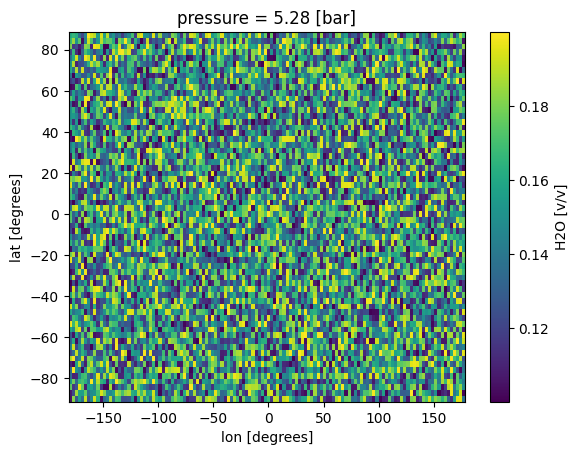

In [5]:
all_gcm['H2O'].isel(pressure=10).plot(x='lon',y='lat')

### Auto-regrid all 3D input

verbose=True;regrid=True; Regridding 3D output to ngangle=20, ntangle=20, with phase=0.


/home/nbatalh1/anaconda3/envs/pic311/lib/python3.11/site-packages/xesmf/smm.py:131: UserWarning: Input array is not C_CONTIGUOUS. Will affect performance.
  warnings.warn('Input array is not C_CONTIGUOUS. ' 'Will affect performance.')


/home/nbatalh1/anaconda3/envs/pic311/lib/python3.11/site-packages/xesmf/smm.py:131: UserWarning: Input array is not C_CONTIGUOUS. Will affect performance.
  warnings.warn('Input array is not C_CONTIGUOUS. ' 'Will affect performance.')


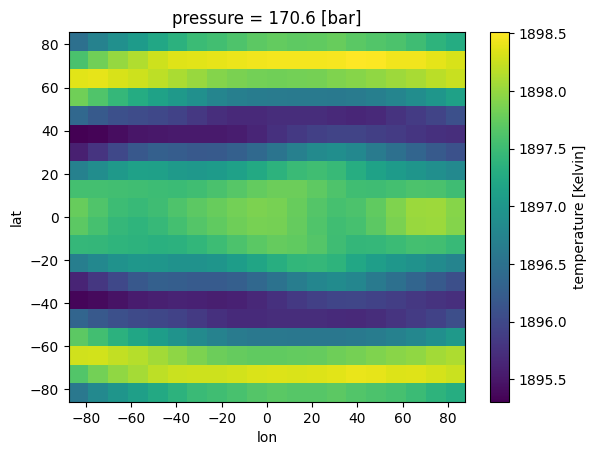

In [6]:
case_3d = jdi.inputs()
case_3d.phase_angle(0, num_tangle=20, num_gangle=20)
case_3d.atmosphere_3d(all_gcm, regrid=True)

Note there is no print warning about missing abundance info since we have added it directly to the input `xarray`

### See regridded abundance input

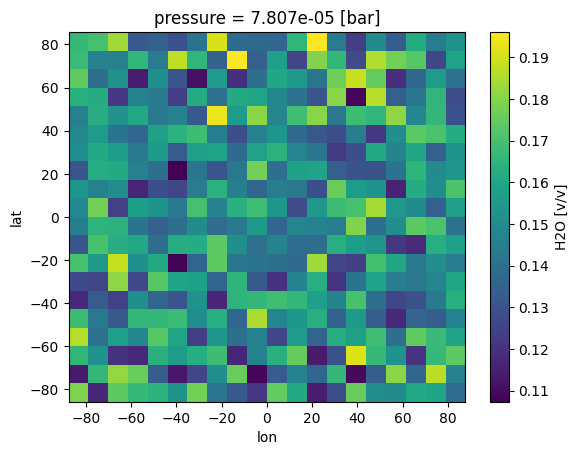

In [7]:
case_3d.inputs['atmosphere']['profile']['H2O'].isel(pressure=10).plot(
    x='lon',y='lat')

## Post-Process Chemistry: Chemical Equilibrium

We will run this example on a very coarse (5x5) grid to make it faster.

First step is the same a above but you will notice a warning that we have yet to add chemistry.

verbose=True;regrid=True; Regridding 3D output to ngangle=5, ntangle=5, with phase=0.
verbose=True;Only one data variable included. Make sure to add in chemical abundances before trying to run spectra.


/home/nbatalh1/anaconda3/envs/pic311/lib/python3.11/site-packages/xesmf/smm.py:131: UserWarning: Input array is not C_CONTIGUOUS. Will affect performance.
  warnings.warn('Input array is not C_CONTIGUOUS. ' 'Will affect performance.')


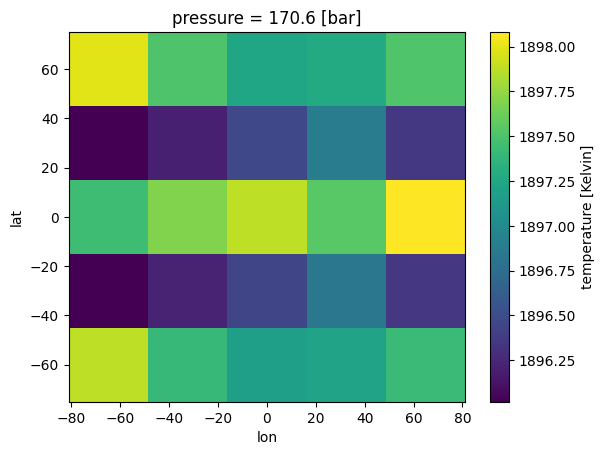

In [8]:
gcm_no_chem =  jdi.HJ_pt_3d(as_xarray=True)
case_3d = jdi.inputs()
case_3d.phase_angle(0, num_tangle=5, num_gangle=5)
case_3d.atmosphere_3d(gcm_no_chem, regrid=True)

In [9]:
case_3d.chemeq_3d(n_cpu=3)#cpu sets parallelization (1=no parallelization)

### Plot 3D Chemistry 

Now we can see structure that intuitively makes sense. Near the equator, where temperatures are hotter, there is less CH4. 

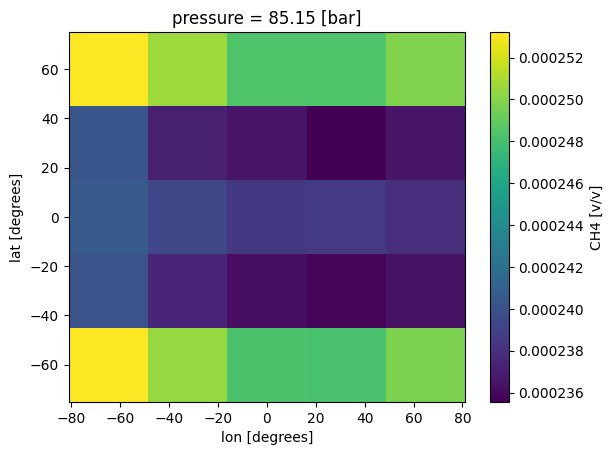

In [10]:
case_3d.inputs['atmosphere']['profile']['CH4'].isel(pressure=50).plot(
    x='lon',y='lat')

Make adjustments to `x` and `y` axes

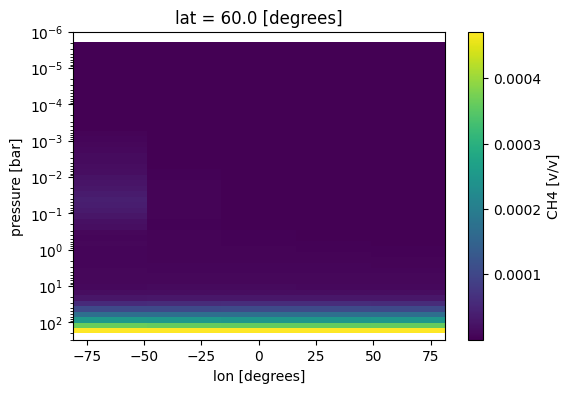

In [11]:
fig, ax = jpi.plt.subplots(figsize=(6, 4))
case_3d.inputs['atmosphere']['profile']['CH4'].isel(lat=0).plot(x='lon',y='pressure',
                                                                ax=ax)
ax.set_ylim([3e2,1e-6])
ax.set_yscale('log')